# **DLAI PROJECT Team 4**

# **Activity 1: Convolutional Autoencoder**

Steps:
1. Load MNIST train and test sets. Split the original training data into 95% training and 5% validation data.
2. Implement a convolutional autoencoder (with separate Encoder and Decoder modules).
3. Train the convolutional autoencoder, with different bottleneck sizes. 
Plot the train and validation loss curves of all autoencoders in the same figure.
4. Compute the avg. image reconstruction error (MSE) of the trained models on the MNIST validation and test sets. 
Show the results in a table, including #params of each model.
5. Select one of the autoencoders and feed it 5 random MNIST images from the test set. Show them along with their reconstructions.
6. Generate 5 new images by injecting random values as input to the decoder. Show them.


Libraries and imports

In [0]:
import torch
import copy
import random
import statistics 
import numpy as np
np.random.seed(7) # To obtain reproducible results
import torch.nn as nn
import torch.optim as optim
torch.manual_seed(1)
import torch.nn.functional as F
import matplotlib.pyplot as plt
#%matplotlib inline
from torchvision import datasets, transforms
from tabulate import tabulate


Used constants

In [0]:
TraiSetSize = 60000
SplitTraning = 95
SplitTraningSize = int(TraiSetSize*SplitTraning/100)
SpitValidationSize = TraiSetSize-SplitTraningSize

Hyper-parameters definition

In [0]:
hparams = {
    'batch_size':64,
    'num_epochs':10,
    'test_batch_size':64,
    'eval_batch_size': 64,
    'hidden_size':128,
    'num_classes':10,
    'num_inputs':784,
    'learning_rate':1e-3,
    'log_interval':100,
    'bottleneck':30,
    'NumImages':5,
    'ex2_batch_size':100
}
hparams['device'] = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.cuda.manual_seed_all(7)

### **1. Load MNIST train and test sets. Split the original training data into 95%** 

Load MNIST train and test sets

In [0]:
# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# load the training and test datasets
mnist_trainset = datasets.MNIST('data', train=True, download=True,
                                transform=transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5,), (0.5,))
                                ]))

mnist_valset =copy.deepcopy(mnist_trainset)

mnist_testset = datasets.MNIST('data', train=False, 
                               transform=transforms.Compose([
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5,), (0.5,))
                               ]))


  0%|          | 0/9912422 [00:00<?, ?it/s]

9920512it [00:00, 28548777.36it/s]                            


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


32768it [00:00, 460867.40it/s]
  1%|          | 16384/1648877 [00:00<00:11, 145330.70it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


1654784it [00:00, 7542989.99it/s]                            
8192it [00:00, 188671.59it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw
Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


Splitting the data into training (95%) and validation (5%)

In [0]:
mnist_trainset.data = mnist_trainset.data[:SplitTraningSize]
mnist_trainset.targets = mnist_trainset.targets[:SplitTraningSize]

mnist_valset.data = mnist_valset.data[SplitTraningSize:TraiSetSize]
mnist_valset.targets = mnist_valset.targets[SplitTraningSize:TraiSetSize]


Data loaders

In [0]:
train_loader = torch.utils.data.DataLoader(
    mnist_trainset,
    batch_size=hparams['batch_size'], 
    shuffle=True)

test_loader = torch.utils.data.DataLoader(
    mnist_testset,
    batch_size=hparams['test_batch_size'], 
    shuffle=False)

val_loader = torch.utils.data.DataLoader(
    mnist_valset,
    batch_size=hparams['eval_batch_size'], 
    shuffle=True)

Lets verify that the split has done correctly by printing each shape

In [0]:
print(mnist_trainset.data.shape)
print(mnist_trainset.targets.shape)

print(mnist_valset.data.shape)
print(mnist_valset.targets.shape)

torch.Size([57000, 28, 28])
torch.Size([57000])
torch.Size([3000, 28, 28])
torch.Size([3000])


### **2. Implement a convolutional autoencoder (with separate Encoder and Decoder modules).**

Encoder

In [0]:
class ConvEncoder(nn.Module):
  def __init__(self,bottlenecksize):
    super().__init__()

    self.conv1 = nn.Conv2d(1, 16, 3, padding=1)  
    self.conv2 = nn.Conv2d(16, 4, 3, padding=1)
    self.pool = nn.MaxPool2d(2, 2)
    self.linear1=nn.Linear(7*7*4, bottlenecksize)
    self.tanh=nn.Tanh()

  def forward(self,x):

    x = F.relu(self.conv1(x))
    x = self.pool(x)
    x = F.relu(self.conv2(x))
    x = self.pool(x) 
    bsz, nch, height, width = x.shape
    x=x.view(bsz,-1)
    x=self.linear1(x)
    encoded=self.tanh(x)

    return encoded


Decoder

In [0]:
class ConvDecoder(nn.Module):
  def __init__(self,bottlenecksize=hparams['bottleneck']):
     super().__init__()

     self.linear1=nn.Linear(bottlenecksize, 7*7*4)
     self.t_conv1 = nn.ConvTranspose2d(4, 16, 2, stride=2)
     self.t_conv2 = nn.ConvTranspose2d(16, 1, 2, stride=2)
     self.tanh=nn.Tanh()

  def forward(self,x):

    x=self.linear1(x)
    upSize=x.size()
    x=x.view(upSize[0], 4, 7, 7)
    x = F.relu(self.t_conv1(x))
    x=self.t_conv2(x)
    decoded=self.tanh(x)
    return decoded

Autoencoder

In [0]:
class ConvAutoencoder(nn.Module):
  def __init__(self, enc, dec):
    super().__init__()

    self.cEnc = enc
    self.cDec = dec

  def forward(self, x):

    x = self.cEnc(x)
    decoded = self.cDec(x)
    return decoded

### **3. Train the convolutional autoencoder, with different bottleneck sizes. Plot the train and validation loss curves of all autoencoders in the same figure.**
### **4. Compute the avg. image reconstruction error (MSE) of the trained models on the MNIST validation and test sets. Show the results in a table, including #params of each model.**

Bottleneck sizes

In [0]:
Neck_Sizes = [2,5,10,15,30]
NumNeckSizes = len(Neck_Sizes)

Definition of arrays where we are going to save for each bottleneck size:


*   Model --> model_trained
*   Training loss curve --> GlobalTrainHistory
*   Validation loss curve --> GlobalValidationHistory
*   Number of iteration after epoch --> GlobalValidationIndex






In [0]:
n_epochs = hparams['num_epochs']
model_trained = []
GlobalTrainHistory = []
GlobalValidationIndex = []
GlobalValidationHistory = []

Training for each bottleneck sizes

In [0]:
for i in range (NumNeckSizes):
  cEncoder=ConvEncoder(Neck_Sizes[i])
  cDecoder=ConvDecoder(Neck_Sizes[i])
  model = ConvAutoencoder(cEncoder, cDecoder)

  criterion = nn.MSELoss()
  optimizer = torch.optim.RMSprop(model.parameters(), lr=hparams['learning_rate'])

  train_history = []
  val_history = []
  test_history = []

  train_hist_epoch_cnt = 0
  train_hist_epoch_indx = []

  model_parameters = filter(lambda p: p.requires_grad, model.parameters())
  params = sum([np.prod(p.size()) for p in model_parameters])
 
  print('\n\nBottleneck size:' + str(Neck_Sizes[i]) + '\nParameters: ' + str(params)+'\n')
  print ("Epoch\t\tTest error(avg)\t\tValidation error(avg)")
  print ("-----------------------------------------------------------------------")

  for epoch in range(1, n_epochs+1):

      train_loss = 0.0
      
      ###################
      # train the model #
      ###################
      for data in train_loader:
          
          images, _ = data
          optimizer.zero_grad()
          outputs = model(images)
          loss = criterion(outputs, images)
          loss.backward()
          optimizer.step()

          train_history.append(loss.item())
          train_loss += loss.item()*images.size(0)
          train_hist_epoch_cnt = train_hist_epoch_cnt + 1

      train_hist_epoch_indx.append(train_hist_epoch_cnt)  
      
      #########################################
      # apply the validaton data to the model #
      #########################################
      val_loss = 0.0
      for data2 in val_loader:
          images2, _ = data2
          outputs = model(images2)

          loss = criterion(outputs, images2)
          val_loss += loss.item()*images2.size(0)
      
      val_loss = round(val_loss/len(val_loader),3)
      val_history.append(loss.item())
   
      #########################################
      # apply the test data to the model #
      #########################################
      test_loss = 0.0
      for data3 in test_loader:
          images3, _ = data3
          outputs = model(images3)

          loss = criterion(outputs, images3)
          test_loss += loss.item()*images3.size(0)

      
      test_loss = round(test_loss/len(test_loader),3)
      test_history.append(test_loss)

      # Print Test MSE
      print('{}'.format(epoch) + '\t\t' + '{0:.3f}'.format(test_loss)+ '\t\t\t' + '{0:.3f}'.format(val_loss))

  # Save the learned model with the currect bottle neck on a model list
  model_trained.append(model)
  
  GlobalTrainHistory.append(train_history)
  GlobalValidationHistory.append(val_history)
  GlobalValidationIndex.append(train_hist_epoch_indx)



Bottleneck size:2
Parameters: 2059

Epoch		Test error(avg)		Validation error(avg)
-----------------------------------------------------------------------
1		17.262			17.138
2		14.776			14.762
3		14.021			14.038
4		13.773			13.787
5		13.624			13.706
6		13.535			13.606
7		13.504			13.546
8		13.560			13.628
9		13.423			13.465
10		13.410			13.486


Bottleneck size:5
Parameters: 3238

Epoch		Test error(avg)		Validation error(avg)
-----------------------------------------------------------------------
1		12.273			12.498
2		11.117			11.278
3		10.496			10.620
4		10.265			10.342
5		10.004			10.075
6		9.894			9.968
7		9.820			9.844
8		9.797			9.817
9		9.767			9.786
10		9.726			9.777


Bottleneck size:10
Parameters: 5203

Epoch		Test error(avg)		Validation error(avg)
-----------------------------------------------------------------------
1		12.103			12.269
2		8.703			8.874
3		8.000			8.178
4		7.587			7.774
5		7.188			7.382
6		7.036			7.193
7		6.864			7.005
8		6.862			6.998
9		6.763			6.880
10		

Plotting of train and validation loss curves of all autoencoders

Text(0, 0.5, 'NLLLoss')

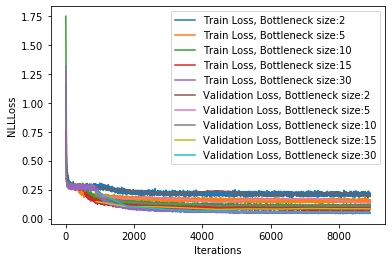

In [0]:
for i in range (NumNeckSizes):
  plt.plot(GlobalTrainHistory[i], label='Train Loss, Bottleneck size:' + str(Neck_Sizes[i]))

for i in range (NumNeckSizes):
  plt.plot(GlobalValidationIndex[i],GlobalValidationHistory[i], label='Validation Loss, Bottleneck size:' + str(Neck_Sizes[i]))

plt.legend()
plt.xlabel('Iterations')
plt.ylabel('NLLLoss')

### **5. Select one of the autoencoders and feed it 5 random MNIST images from the test set. Show them along with their reconstructions.**

Select the index of Neck_Sizes (position in the array of the bottleneck sizes we are goint to use)
Definition of the autoencoder we are going to use

In [0]:
ChooseModelInd = 3 #Bottleneck size = 15
ChooseModel =model_trained[ChooseModelInd]

Selection of 5 random MNIST images from the test set

In [0]:
n = hparams['NumImages']

dataiter = iter(test_loader)
images, labels = dataiter.next()
ps=abs(np.random.random_integers(images.shape[0])-n)
images= images.data[ps:ps+n]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: This function is deprecated. Please call randint(1, 64 + 1) instead
  """


Feed our autoencoder with the selected test set images and plot comparison

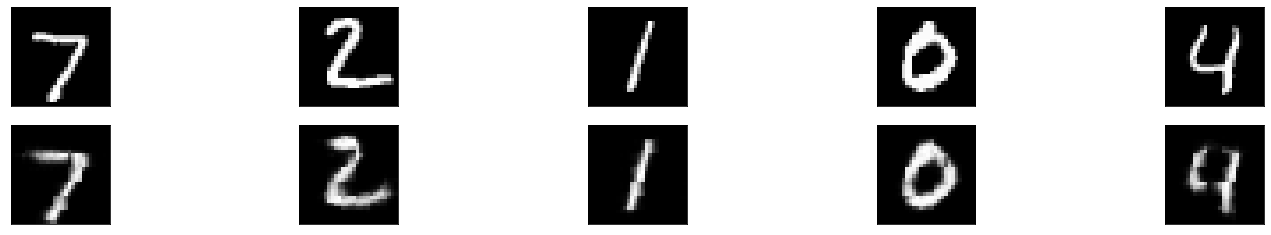

In [0]:
output = ChooseModel(images)

images = images.numpy()

output = output.view(n, 1, 28, 28)
output = output.detach().numpy()

fig, axes = plt.subplots(nrows=2, ncols=n, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images+ps, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

### **6. Generate 5 new images by injecting random values as input to the decoder. Show them.**

Generation of random values that we will use as input to the decoder (random values between logical interval at the output of our encoder)

In [0]:
x=torch.tensor(torch.FloatTensor(1,Neck_Sizes[ChooseModelInd]).normal_(0,0.5))
for i in range (hparams['batch_size']-1):
  x= torch.cat([x, torch.FloatTensor(1,Neck_Sizes[ChooseModelInd]).normal_(0, 0.5)], dim=0) 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


Injection of these random input to the decoder

In [0]:
output = ChooseModel.cDec(x)
output = output.detach().numpy()

Plotting of images that provide our decoder after injecting random input

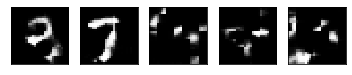

In [0]:
for i in range(n):
    # display reconstruction
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(output[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# **Activity 2: Transfer Learning**

Steps:
1. Select a subset of 100 images and their associated labels from the MNIST training data.
2. Select one of the previously trained autoencoders.
3. Create a digit (0-9) classification model reusing the encoder of the autoencoder and adding the needed fully connected (projection) layer.
4. Pre-training: use the weights of the autoencoder as initial values for the network weights and train a classification model on the subset of 100 samples.
5. Fine-tuning: do the same, but train the new projection layer with a normal learning rate and the reused part with a very low learning rate.
6. From scratch: train the model on the 100 samples without reusing the encoder weights at all.
7. Show the accuracy of the three models on the MNIST test set in a table.


### **1. Select a subset of 100 images and their associated labels from the MNIST training data.**

In [0]:
# Create a copy to not trim the original trainset
mnist_traindata =copy.deepcopy(mnist_trainset)

ps=abs(np.random.random_integers(mnist_traindata.data.shape[0]-100))

mnist_traindata.data = mnist_traindata.data[ps:ps+100]
mnist_traindata.targets = mnist_traindata.targets[ps:ps+100]

traind_loader = torch.utils.data.DataLoader(
    mnist_traindata,
    batch_size=hparams['ex2_batch_size'], 
    shuffle=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: This function is deprecated. Please call randint(1, 56900 + 1) instead
  This is separate from the ipykernel package so we can avoid doing imports until


Verification of the selected subset shape

In [0]:
print(mnist_traindata.data.shape)
print(mnist_traindata.targets.shape)

torch.Size([100, 28, 28])
torch.Size([100])


In [0]:
iter_ = iter(traind_loader)
bimg, blabel = next(iter_)
print('Batch Img shape: ', bimg.shape)
print('Batch Label shape: ', blabel.shape)
print('The Batched tensors return a collection of {} grayscale images ({} channel, {} height pixels, {} width pixels)'.format(bimg.shape[0],
                                                                                                                              bimg.shape[1],
                                                                                                                              bimg.shape[2],
                                                                                                                              bimg.shape[3]))

Batch Img shape:  torch.Size([100, 1, 28, 28])
Batch Label shape:  torch.Size([100])
The Batched tensors return a collection of 100 grayscale images (1 channel, 28 height pixels, 28 width pixels)


### **2. Select one of the previously trained autoencoders.**

In [0]:
Autoencoder = ChooseModel

### **3. Create a digit (0-9) classification model reusing the encoder of the autoencoder and adding the needed fully connected (projection) layer.**

Classificator

In [0]:
class Clasificator(nn.Module):
  def __init__(self,bottlenecksize):
    super().__init__()
    self.linear1=nn.Linear(bottlenecksize, hparams['hidden_size'])
    self.linear2=nn.Linear(hparams['hidden_size'], hparams['num_classes'])
    self.logsoftmax=nn.LogSoftmax()

  def forward(self,x):
    x = self.linear1(x)
    x = F.relu(x)
    x = self.linear2(x)
    clasif = self.logsoftmax(x)

    return clasif

Classification model created by reusing the encoder and adding the fully connected layer

In [0]:
class ClasificationModel(nn.Module):
  def __init__(self, enc, clasif):
    super().__init__()

    self.cEnc = enc
    self.cClasif = clasif

  def forward(self, x):

    x = self.cEnc(x)
    Clasified = self.cClasif(x)

    return Clasified

### **4. Pre-training: use the weights of the autoencoder as initial values for the network weights and train a classification model on the subset of 100 samples.**

Choose the model we are going to use

In [0]:
cClasificator = Clasificator(Neck_Sizes[ChooseModelInd])
PreTraining_model = ClasificationModel(Autoencoder.cEnc, cClasificator)

Define criterion and optimizer and average weight

In [0]:
criterion=F.nll_loss
optimizer=optim.RMSprop(params=PreTraining_model.parameters(), lr=hparams['learning_rate'], alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)
avg_loss = None
avg_weight = 0.1

Definition of the funtion that returns the accuracy of the prediction

In [0]:
def correct_predictions(predicted_batch, label_batch):
  pred = predicted_batch.argmax(dim=1, keepdim=True) # get the index of the max log-probability
  acum = pred.eq(label_batch.view_as(pred)).sum().item()
  return acum

Training function definition

In [0]:
def train_epoch(train_loader, network, optimizer, criterion, hparams):
  network.train()
  device = hparams['device']
  avg_loss = None
  avg_weight = 0.1
  for batch_idx, (data, target) in enumerate(train_loader):
      data, target = data.to(device), target.to(device)
      network=network.to(device)
      optimizer.zero_grad()
      output = network(data)
      loss = criterion(output, target)
      loss.backward()
      if avg_loss:
        avg_loss = avg_weight * loss.item() + (1 - avg_weight) * avg_loss
      else:
        avg_loss = loss.item()
      optimizer.step()
      if batch_idx % hparams['log_interval'] == 0:
          print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
              epoch, batch_idx * len(data), len(train_loader.dataset),
              100. * batch_idx / len(train_loader), loss.item()))
  return avg_loss

Testing function definition

In [0]:
def test_epoch(test_loader, network, hparams):
    network.eval()
    device = hparams['device']
    test_loss = 0
    acc = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            network=network.to(device)
            output = network(data)
            test_loss += criterion(output, target, reduction='sum').item() 
            acc += correct_predictions(output, target)
    test_loss /= len(test_loader.dataset)
    test_acc = 100. * acc / len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, acc, len(test_loader.dataset), test_acc,
        ))
    return test_loss, test_acc

Training

In [0]:
train_losses = []
test_losses = []
test_accs_1 = []

for epoch in range(1, hparams['num_epochs'] + 1):
  train_losses.append(train_epoch(traind_loader, PreTraining_model, optimizer, criterion, hparams))

  test_loss,test_accuracy=test_epoch(test_loader, PreTraining_model, hparams)
  
  test_losses.append(test_loss)
  test_accs_1.append(test_accuracy)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


Train Epoch: 1 [0/100 (0%)]	Loss: 2.296020

Test set: Average loss: 2.2178, Accuracy: 3516/10000 (35%)

Train Epoch: 2 [0/100 (0%)]	Loss: 2.177933

Test set: Average loss: 2.1021, Accuracy: 4446/10000 (44%)

Train Epoch: 3 [0/100 (0%)]	Loss: 2.004351

Test set: Average loss: 1.9823, Accuracy: 5202/10000 (52%)

Train Epoch: 4 [0/100 (0%)]	Loss: 1.832121

Test set: Average loss: 1.9157, Accuracy: 4296/10000 (43%)

Train Epoch: 5 [0/100 (0%)]	Loss: 1.680094

Test set: Average loss: 1.7584, Accuracy: 5608/10000 (56%)

Train Epoch: 6 [0/100 (0%)]	Loss: 1.503803

Test set: Average loss: 1.6826, Accuracy: 5347/10000 (53%)

Train Epoch: 7 [0/100 (0%)]	Loss: 1.327421

Test set: Average loss: 1.5536, Accuracy: 6012/10000 (60%)

Train Epoch: 8 [0/100 (0%)]	Loss: 1.189398

Test set: Average loss: 1.5260, Accuracy: 5832/10000 (58%)

Train Epoch: 9 [0/100 (0%)]	Loss: 1.088579

Test set: Average loss: 1.4515, Accuracy: 5919/10000 (59%)

Train Epoch: 10 [0/100 (0%)]	Loss: 1.004798

Test set: Average l

Plotting the obtained results

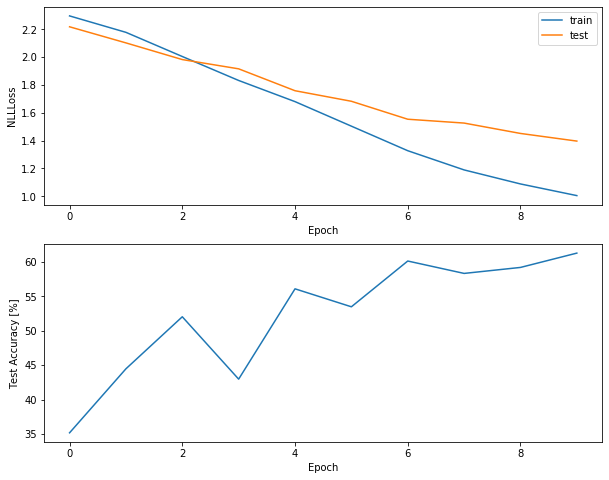

In [0]:
plt.figure(figsize=(10, 8))
plt.subplot(2,1,1)
plt.xlabel('Epoch')
plt.ylabel('NLLLoss')

plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.legend()
plt.subplot(2,1,2)
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy [%]')
plt.plot(test_accs_1)

### **5. Fine-tuning: do the same, but train the new projection layer with a normal learning rate and the reused part with a very low learning rate.**

First, we will define the Optimizer with different LR for each section of the model.

In [0]:
print(PreTraining_model.cEnc)
print(PreTraining_model.cClasif)

ConvEncoder(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=196, out_features=15, bias=True)
  (tanh): Tanh()
)
Clasificator(
  (linear1): Linear(in_features=15, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=10, bias=True)
  (logsoftmax): LogSoftmax()
)


In [0]:
optimizer = optim.RMSprop([
                {'params': PreTraining_model.cEnc.parameters()},
                {'params': PreTraining_model.cClasif.parameters(), 'lr': 1e-9}
            ], lr=hparams['learning_rate'] , momentum=0)

Now, we will try the model with the new LRs.

In [0]:
# Init lists to save the evolution of the training & test losses/accuracy.
train_losses = []
test_losses = []
test_accs_2 = []

for epoch in range(1, hparams['num_epochs'] + 1):
  train_losses.append(train_epoch(traind_loader, PreTraining_model, optimizer, criterion, hparams))

  test_loss,test_accuracy=test_epoch(test_loader, PreTraining_model, hparams)
  
  test_losses.append(test_loss)
  test_accs_2.append(test_accuracy)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


Train Epoch: 1 [0/100 (0%)]	Loss: 0.888054

Test set: Average loss: 1.5784, Accuracy: 5170/10000 (52%)

Train Epoch: 2 [0/100 (0%)]	Loss: 1.177808

Test set: Average loss: 1.4075, Accuracy: 5897/10000 (59%)

Train Epoch: 3 [0/100 (0%)]	Loss: 0.836265

Test set: Average loss: 1.3207, Accuracy: 6311/10000 (63%)

Train Epoch: 4 [0/100 (0%)]	Loss: 0.794611

Test set: Average loss: 1.3250, Accuracy: 6240/10000 (62%)

Train Epoch: 5 [0/100 (0%)]	Loss: 0.774203

Test set: Average loss: 1.3076, Accuracy: 6332/10000 (63%)

Train Epoch: 6 [0/100 (0%)]	Loss: 0.759276

Test set: Average loss: 1.3028, Accuracy: 6332/10000 (63%)

Train Epoch: 7 [0/100 (0%)]	Loss: 0.747457

Test set: Average loss: 1.2966, Accuracy: 6368/10000 (64%)

Train Epoch: 8 [0/100 (0%)]	Loss: 0.736969

Test set: Average loss: 1.2871, Accuracy: 6395/10000 (64%)

Train Epoch: 9 [0/100 (0%)]	Loss: 0.726677

Test set: Average loss: 1.2844, Accuracy: 6425/10000 (64%)

Train Epoch: 10 [0/100 (0%)]	Loss: 0.717658

Test set: Average l

Plotting of the new results

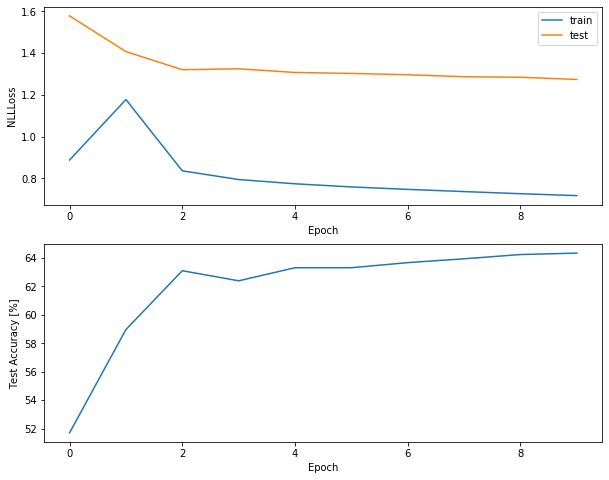

In [0]:
plt.figure(figsize=(10, 8))
plt.subplot(2,1,1)
plt.xlabel('Epoch')
plt.ylabel('NLLLoss')

plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.legend()
plt.subplot(2,1,2)
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy [%]')
plt.plot(test_accs_2)

### **6. From scratch: train the model on the 100 samples without reusing the encoder weights at all.**

First, intead of reusing the already trained encoder from Exercise 1, let's create a brand new ENCODER.

In [0]:
newEnc = ConvEncoder(Neck_Sizes[ChooseModelInd])

Now, lets add it to our new Classifier:

In [0]:
FromScratch_model = ClasificationModel(newEnc, cClasificator)
print(FromScratch_model)
optimizer=optim.RMSprop(params=FromScratch_model.parameters(), lr=hparams['learning_rate'], alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)

ClasificationModel(
  (cEnc): ConvEncoder(
    (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (linear1): Linear(in_features=196, out_features=15, bias=True)
    (tanh): Tanh()
  )
  (cClasif): Clasificator(
    (linear1): Linear(in_features=15, out_features=128, bias=True)
    (linear2): Linear(in_features=128, out_features=10, bias=True)
    (logsoftmax): LogSoftmax()
  )
)


Lets train the new model:

In [0]:
train_losses = []
test_losses = []
test_accs_3 = []

for epoch in range(1, hparams['num_epochs'] + 1):
  train_losses.append(train_epoch(traind_loader, FromScratch_model, optimizer, criterion, hparams))

  test_loss,test_accuracy=test_epoch(test_loader, FromScratch_model, hparams)
  
  test_losses.append(test_loss)
  test_accs_3.append(test_accuracy)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


Train Epoch: 1 [0/100 (0%)]	Loss: 2.301938

Test set: Average loss: 2.3094, Accuracy: 1010/10000 (10%)

Train Epoch: 2 [0/100 (0%)]	Loss: 2.258374

Test set: Average loss: 2.2475, Accuracy: 1408/10000 (14%)

Train Epoch: 3 [0/100 (0%)]	Loss: 2.213671

Test set: Average loss: 2.1108, Accuracy: 3129/10000 (31%)

Train Epoch: 4 [0/100 (0%)]	Loss: 1.996302

Test set: Average loss: 2.3912, Accuracy: 2132/10000 (21%)

Train Epoch: 5 [0/100 (0%)]	Loss: 2.298452

Test set: Average loss: 2.0576, Accuracy: 2329/10000 (23%)

Train Epoch: 6 [0/100 (0%)]	Loss: 1.900678

Test set: Average loss: 1.8549, Accuracy: 4939/10000 (49%)

Train Epoch: 7 [0/100 (0%)]	Loss: 1.688356

Test set: Average loss: 1.7433, Accuracy: 4875/10000 (49%)

Train Epoch: 8 [0/100 (0%)]	Loss: 1.466238

Test set: Average loss: 1.5992, Accuracy: 4679/10000 (47%)

Train Epoch: 9 [0/100 (0%)]	Loss: 1.391453

Test set: Average loss: 1.9603, Accuracy: 2990/10000 (30%)

Train Epoch: 10 [0/100 (0%)]	Loss: 1.454022

Test set: Average l

Plotting the results:

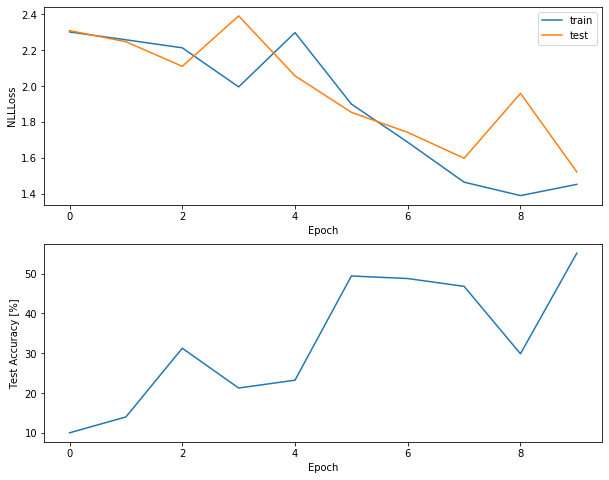

In [0]:
plt.figure(figsize=(10, 8))
plt.subplot(2,1,1)
plt.xlabel('Epoch')
plt.ylabel('NLLLoss')

plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.legend()
plt.subplot(2,1,2)
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy [%]')
plt.plot(test_accs_3)

### **7. Show the accuracy of the three models on the MNIST test set in a table.**

In [0]:
print(tabulate([["Model","Accuracy"],["Pre-Training",max(test_accs_1)],["Fine-Tunning",max(test_accs_2)],["From-Scratch",max(test_accs_3)]],headers="firstrow"))

Model           Accuracy
------------  ----------
Pre-Training       61.27
Fine-Tunning       64.35
From-Scratch       55.12
